# Conjugate Families (Part II)

### Goals 
- **Practice building Bayesian models.** You will build Bayesian models by practicing how to recognize kernels and make use of proportionality.
- **Familiarize yourself with conjugacy.** You will learn about what makes a prior conjugate and why this is a helpful property. In brief, conjugate priors make it easier to build posterior models. Conjugate priors spark joy!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, binom, gamma, uniform, poisson, norm
from empiricaldist import Pmf

import utils as ut

# Brain health and the dangers of concussions

Consider a data story. As scientists learn more about brain health, the dangers of concussions (hence of activities in which participants sustain repeated concussions) are gaining greater attention [Bachynski, **2019**](https://uncpress.org/book/9781469653709/no-game-for-boys-to-play/). Among all people who have a history of concussions, we are interested in $\mu$, the average volume (in cubic centimeters) of a specific part of the brain: the hippocampus. 

Though we don't have prior information about this group in particular, **Wikipedia** tells us that among the general population of human adults, both halves of the hippocampus have a volume between 3.0 and 3.5 cubic centimeters.$^{2}$ Thus, the _total_ hippocampal volume of _both_ sides of the brain is between 6 and 7 cm$^3$. Using this as a starting point, we'll assume that the mean hippocampal volume among people with a history of concussions, $\mu$, is also somewhere between 6 and 7 cm$^3$, with an average of 6.5.

## The Normal model

Let $Y$ be a continuous random variable which can take any value between $-\infty$ and $\infty$, i.e., $Y \in (-\infty, \infty)$. Then the variability in $Y$ might be well represented by a Normal model with **mean parameter** $\mu \in (-\infty, \infty)$ and **standard deviation parameter** $\sigma > 0$:

$$ Y \sim N(\mu, \sigma^2). $$

The Normal model is specified by the continuous pdf:

$$ f(y) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[ -\frac{(y - \mu)^2}{2\sigma^2} \right] \quad \text{for } y \in (-\infty, \infty). $$

and has the following features:

$$
\begin{aligned}
E(Y) & = \text{Mode}(Y) = \mu \\
\text{Var}(Y) & = \sigma^2 \\
\text{SD}(Y) & = \sigma.
\end{aligned}
$$

Further, $\sigma$ provides a sense of scale for $Y$. Roughly 95% of $Y$ values will be within 2 standard deviations of $\mu$:

$$ \mu \pm 2\sigma. $$


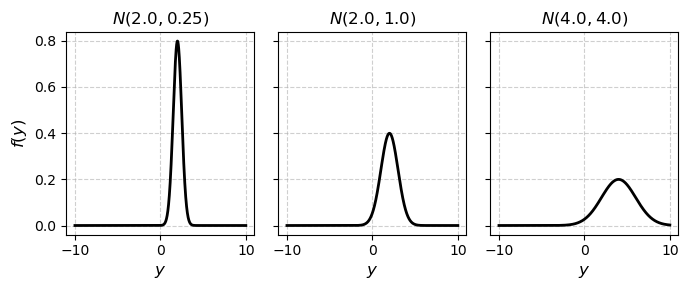

In [2]:
# Define parameters for the three normal distributions
params = [(2.0, 0.5**2), (2.0, 1**2), (4.0, 2**2)]
x = np.linspace(-10, 10, 2000)

# Create figure and axes
fig, axes = plt.subplots(1, 3, figsize=(7, 3), sharey=True)

# Plot each normal distribution
for ax, (mu, sigma2) in zip(axes, params):
    sigma = np.sqrt(sigma2)
    y = norm.pdf(x, mu, sigma)
    ax.plot(x, y, 'k', linewidth=2)
    ax.set_title(f'$N({mu}, {sigma**2})$', fontsize=12)
    ax.set_xlabel('$y$', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

axes[0].set_ylabel('$f(y)$', fontsize=12)

plt.tight_layout()
plt.show()


### The Normal data model

Returning to our brain analysis, we can reasonably assume that the hippocampal volumes of our studied subjects, $(Y_1, Y_2, \dots, Y_n)$, are _independent_ and Normally distributed around a mean volume $\mu$ with standard deviation $\sigma$. Further, to keep our focus on $\mu$, **_we'll assume throughout our analysis that the standard deviation is known_** to be $\sigma = 0.5$ cm$^3$. This choice of $\sigma$ suggests that most people have hippocampal volumes within $2\sigma = 1$ cm$^3$ of the average. Thus, the dependence of $Y_i$ on the _unknown_ mean $\mu$ is:

$$ Y_i \mid \mu \sim N(\mu, \sigma^2). $$

Accordingly, the **joint pdf** which describes the _collective_ randomness in our $n = 25$ subjects' hippocampal volumes, $(Y_1, Y_2, \dots, Y_n)$, is the product of the unique Normal pdfs $f(y_i \mid \mu)$ defined by

$$
f(\vec{y} \mid \mu) = \prod_{i=1}^{n} f(y_i \mid \mu) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[ -\frac{(y_i - \mu)^2}{2\sigma^2} \right].
$$

Once we observe our sample data $\vec{y}$, we can flip the joint pdf on its head to obtain the Normal likelihood function of $\mu$, $L(\mu \mid \vec{y}) = f(\vec{y} \mid \mu)$. Remembering that we're assuming $\sigma$ is a known constant, we can simplify the likelihood up to a _proportionality_ constant by dropping the terms that don't depend upon $\mu$. Then for $\mu \in (-\infty, \infty)$,

$$
L(\mu \mid \vec{y}) \propto \prod_{i=1}^{n} \exp\left[ -\frac{(y_i - \mu)^2}{2\sigma^2} \right] = \exp\left[ -\frac{\sum_{i=1}^{n} (y_i - \mu)^2}{2\sigma^2} \right].
$$

Through a bit more rearranging (which we encourage you to verify if, like us, you enjoy algebra), we can make this even easier to digest by using the sample mean $\bar{y}$ and sample size $n$ to summarize our data values:

$$
L(\mu \mid \vec{y}) \propto \exp\left[ -\frac{(\bar{y} - \mu)^2}{2\sigma^2 / n} \right] \quad \text{for } \mu \in (-\infty, \infty).
$$

Don't forget the whole point of this exercise! Specifying a model for the data along with its corresponding likelihood function provides the tools we'll need to assess the compatibility of our data $\vec{y}$ with different values of $\mu$ (once we actually collect that data).


### The Normal prior model

With the likelihood in place, let's formalize a prior model for $\mu$, the mean hippocampal volume among people that have a history of concussions. By the properties of the $Y_i | \mu \sim N(\mu, \sigma^2)$ data model, the Normal mean parameter $\mu$ can technically take any value between $-\infty$ and $\infty$. Thus, a Normal prior for $\mu$, which is also defined for $\mu \in (-\infty, \infty)$, makes a reasonable choice. Specifically, we'll assume that $\mu$ itself is Normally distributed around some mean $\theta$ with standard deviation $\tau$:

$$
\mu \sim N(\theta, \tau^2),
$$

where $\mu$ has prior pdf

$$
f(\mu) = \frac{1}{\sqrt{2\pi\tau^2}} \exp \left[ -\frac{(\mu - \theta)^2}{2\tau^2} \right] \quad \text{for } \mu \in (-\infty, \infty).
$$

Not only does the Normal prior assumption that $\mu \in (-\infty, \infty)$ match the same assumption of the Normal data model, we'll prove below that this is a *conjugate prior*. You might anticipate this result from the fact that the likelihood function $L(\mu | \mathbf{y})$ and prior pdf $f(\mu)$ are both proportional to

$$
\exp\left[ -\frac{(\mu - \blacksquare)^2}{2\blacksquare^2} \right]
$$

with different ■.

Using our understanding of a Normal model, we can now *tune* the prior hyperparameters $\theta$ and $\tau$ to reflect our prior understanding and uncertainty about the average hippocampal volume among people that have a history of concussions, $\mu$. Based on our rigorous **Wikipedia** research that hippocampal volumes tend to be between 6 and 7 cm³, we'll set the Normal prior mean $\theta$ to the midpoint, 6.5. Further, we'll set the Normal prior standard deviation to $\tau = 0.4$. In other words, we think there's a 95% chance that $\mu$ is somewhere between 5.7 and 7.3 cm³ ( $6.5 \pm 2 \times 0.4$). This range is *wider*, and hence more conservative, than what **Wikipedia** indicated. 

Our uncertainty here reflects the fact that we didn't vet the **Wikipedia** sources, we aren't confident that the features for the typical adult translate to people with a history of concussions, and we generally aren't sure what's going on here (i.e., we're not brain experts). 

Putting this together, our tuned prior model for $\mu$ is:

$$
\mu\sim N(6.5,0.4^2)
$$


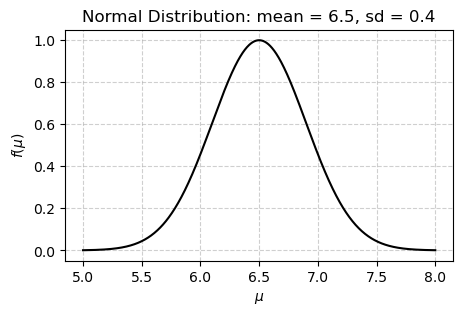

In [9]:
# Define the mean and standard deviation
mean = 6.5
std_dev = 0.4

# Generate x values
x = np.linspace(5, 8, 1000)

# Compute the normal distribution pdf
y = norm.pdf(x, mean, std_dev)

# Plot the normal distribution
plt.figure(figsize=(5, 3))
plt.plot(x, y, color='black')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$f(\mu)$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Normal Distribution: mean = 6.5, sd = 0.4")
plt.show()


### The Normal-Normal Bayesian model

Let $\mu \in (-\infty, \infty)$ be an unknown *mean* parameter and 
$(Y_1, Y_2, \dots, Y_n)$ be an independent $N(\mu, \sigma^2)$ sample where $\sigma$ is assumed to be *known*. The Normal-Normal Bayesian model complements the Normal data structure with a Normal prior on $\mu$:

$$
Y_i | \mu \sim N(\mu, \sigma^2)
$$

$$
\mu \sim N(\theta, \tau^2)
$$

Upon observing data $\vec{y} = (y_1, y_2, \dots, y_n)$ with mean $\bar{y}$, the posterior model of $\mu$ is also Normal with updated parameters:

$$
\mu \mid \vec{y} \sim N \left( \theta \frac{\sigma^2}{n\tau^2 + \sigma^2} + \bar{y} \frac{n\tau^2}{n\tau^2 + \sigma^2}, \frac{\tau^2 \sigma^2}{n\tau^2 + \sigma^2} \right).
$$

Whooo, that is a mouthful! Even without that proof, we can observe the balance that the Normal posterior strikes between the prior and the data. First, the posterior mean is a **weighted average** of the prior mean $E(\mu) = \theta$ and the sample mean $\bar{y}$. Second, the posterior variance is informed by the prior variability $\tau$ and variability in the data $\sigma$. Both are impacted by sample size $n$. First, as $n$ increases, the posterior mean places less weight on the prior mean and more weight on sample mean $\bar{y}$:
$$
\frac{\sigma^2}{n\tau^2+\sigma^2} \to 0 \quad \text{and} \quad \frac{n\tau^2}{n\tau^2+\sigma^2} \to 1.
$$

Further, as $n$ increases, the posterior variance decreases:

$$
\frac{\tau^2\sigma^2}{n\tau^2+\sigma^2} \to 0.
$$

That is, the more and more data we have, our posterior certainty about $\mu$ increases and becomes more in sync with the data.


## Brain health and the dangers of concussions. Dataset

In [11]:
import pandas as pd

# Define the file path
file_path = "FootballBrain.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)
df

,Group,Hipp,LeftHipp,Years,Cogniton
0,Control,6175,2945,0,NaN
1,Control,6220,3075,0,NaN
2,Control,6360,3125,0,NaN
3,Control,6465,3160,0,NaN
4,Control,6540,3205,0,NaN
...,...,...,...,...,...
70,FBConcuss,6190,3045,14,71.0
71,FBConcuss,6420,3155,13,NaN
72,FBConcuss,6445,3200,15,88.0
73,FBConcuss,6635,3255,9,NaN


A dataset with 75 observations on the following 5 variables.

| **Variable**  | **Description**  |
|--------------|----------------|
| **Group**   | `Control` = no football, `FBNoConcuss` = football player but no concussions, or `FBConcuss` = football player with concussion history |
| **Hipp**    | Total hippocampus volume, in microL |
| **LeftHipp** | Left hippocampus volume, in microL |
| **Years**   | Number of years playing football |
| **Cognition** | Cognitive testing composite reaction time score, given as a percentile |


## Exercises (Important)

Using the previous information, so far, we have:

$$
\mu \sim N(6.5, 0.4^2)
$$

$$
Y_i \mid \mu \sim N(\mu, \sigma^2),
$$

where we assume a known standard deviation among individual hippocampal volumes, given by $\sigma = 0.5$ cm³.

### Analysis Using the *FootballBrain* Dataset

Now, using the *FootballBrain* dataset and the previously defined prior:

1. **Compute the likelihoods**:
   Calculate the sample mean hippocampal volume and the sample size for each group in the study.

2. **Identify the posterior model**:
   Derive the posterior distribution of $\mu$ for each group.

3. **Visualize the distributions**:
   Plot the prior probability density function (pdf), the likelihood function, and the posterior pdf of $\mu$ for each group separately. Then, overlay the posterior distributions of each group in a single plot for comparison.

Now, we aim to "classify" individuals based on their hippocampal volume regarding whether they play football:

4. **Update the posterior for football players**:
   Recalculate the distribution for $\mu$ specifically for individuals who play football.

5. **Probability of Playing Football**:
   Given an individual with hippocampal volume $6253 \pm 350$ microL, determine the probability that this person plays football.
